<a href="https://colab.research.google.com/github/Dmitze/Dmitze/blob/main/%D0%94%D0%97_%D0%A2%D0%B5%D0%BC%D0%B0_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання — Тема 6: Аналіз Фур'є та спектрограми

**Мета:** застосувати перетворення Фур'є для побудови спектрограм аудіосигналів із датасету ESC-50, а потім кластеризувати ці сигнали за допомогою SpectralClustering.

**Класи:** `dog` (гавкіт) та `chirping_birds` (спів птахів)

In [16]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from urllib.request import urlretrieve
from IPython.display import Audio
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

np.random.seed(42)

# 1. Завантаження датасету ESC-50

In [17]:
url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
zip_path = "ESC-50-master.zip"
dataset_path = "./ESC-50-master/"

if not os.path.exists(dataset_path):
    print("Завантажую ESC-50, чекайте...")
    urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(dataset_path)
    os.remove(zip_path)
    print("Готово!")
else:
    print("Датасет вже є, пропускаю")

Датасет вже є, пропускаю


# 2 Використання в задачах обробки звуку

In [18]:
# Беру один конкретний файл — просто подивитись що взагалі є в датасеті
audio_file_path = os.path.join(dataset_path, "ESC-50-master/audio", "1-59513-A-0.wav")
y, sr = librosa.load(audio_file_path, sr=None)

print(f"Завантажено аудіо файл: {audio_file_path}")
print(f"Довжина аудіо: {len(y)} зразків")
print(f"Частота дискретизації: {sr} Гц")

Audio(audio_file_path)

Завантажено аудіо файл: ./ESC-50-master/ESC-50-master/audio/1-59513-A-0.wav
Довжина аудіо: 220500 зразків
Частота дискретизації: 44100 Гц


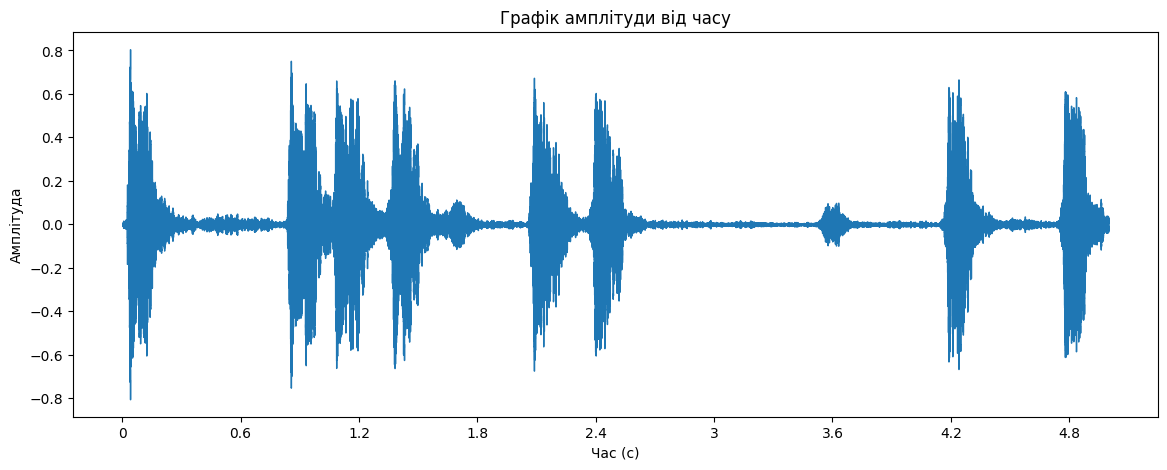

In [19]:
# часова область — бачимо як амплітуда змінюється з часом
# це ще не частоти, просто "гучність у кожен момент"
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Графік амплітуди від часу')
plt.xlabel('Час (с)')
plt.ylabel('Амплітуда')
plt.show()

# 3. Вибираю тільки dog та chirping_birds

In [20]:
csv_path = os.path.join(dataset_path, "ESC-50-master/meta/esc50.csv")
df = pd.read_csv(csv_path)

df_sub = df[df['category'].isin(['dog', 'chirping_birds'])].reset_index(drop=True)
print(f"Файлів у вибірці: {len(df_sub)}")
print(df_sub['category'].value_counts())
df_sub.head()

Файлів у вибірці: 80
category
dog               40
chirping_birds    40
Name: count, dtype: int64


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-110389-A-0.wav,1,0,dog,True,110389,A
3,1-30226-A-0.wav,1,0,dog,True,30226,A
4,1-30344-A-0.wav,1,0,dog,True,30344,A


##◀**Google sheet** ▶

In [21]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_sub)

https://docs.google.com/spreadsheets/d/1VJIrqGZpYzJTdPGTgzlF6Qn06d7ioibYD2jnwYiDLaI/edit#gid=0


# 4. Функції для генерації ознак

In [22]:
def make_spectrogram(samples, sample_rate, stride_ms=10.0, window_ms=20.0, eps=1e-14):
    """STFT: ковзне вікно -> FFT по кожному -> матриця частота x час"""
    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]

    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, shape=nshape, strides=nstrides)

    weighting = np.hanning(window_size)[:, None]  # щоб не було розривів на краях
    fft_vals = np.fft.rfft(windows * weighting, axis=0)
    fft_vals = np.absolute(fft_vals) ** 2

    scale = np.sum(weighting**2) * sample_rate
    fft_vals[1:-1, :] *= (2.0 / scale)
    fft_vals[(0, -1), :] /= scale

    return np.log(fft_vals + eps)

In [23]:
def pooling(mat, ksize, method='max'):
    """Зменшуємо матрицю блочним пулінгом — аналог того що в CNN"""
    m, n = mat.shape
    ky, kx = ksize
    ny, nx = m // ky, n // kx
    mat_cut = mat[:ny*ky, :nx*kx]
    reshaped = mat_cut.reshape(ny, ky, nx, kx)
    if method == 'max':
        return np.nanmax(reshaped, axis=(1, 3))
    return np.nanmean(reshaped, axis=(1, 3))

# 5. Будую матрицю ознак: спектрограма, пулінг, вектор

In [24]:
audio_dir = os.path.join(dataset_path, "ESC-50-master/audio")
POOL_SIZE = (10, 10)  # можна поекспериментувати — чим більше, тим менший вектор

features = []
labels = []

for _, row in df_sub.iterrows():
    path = os.path.join(audio_dir, row['filename'])
    y, sr = librosa.load(path, sr=22050, duration=5.0)  # 5 сек — стандарт ESC-50

    spec = make_spectrogram(y, sr)
    pooled = pooling(spec, POOL_SIZE)
    features.append(pooled.flatten())
    labels.append(row['category'])

X = np.array(features)
y_true = np.array(labels)
print(f"Матриця ознак: {X.shape}  ({X.shape[0]} файлів × {X.shape[1]} ознак)")

Матриця ознак: (80, 1100)  (80 файлів × 1100 ознак)


# 6. Порівнюю спектрограми двох класів

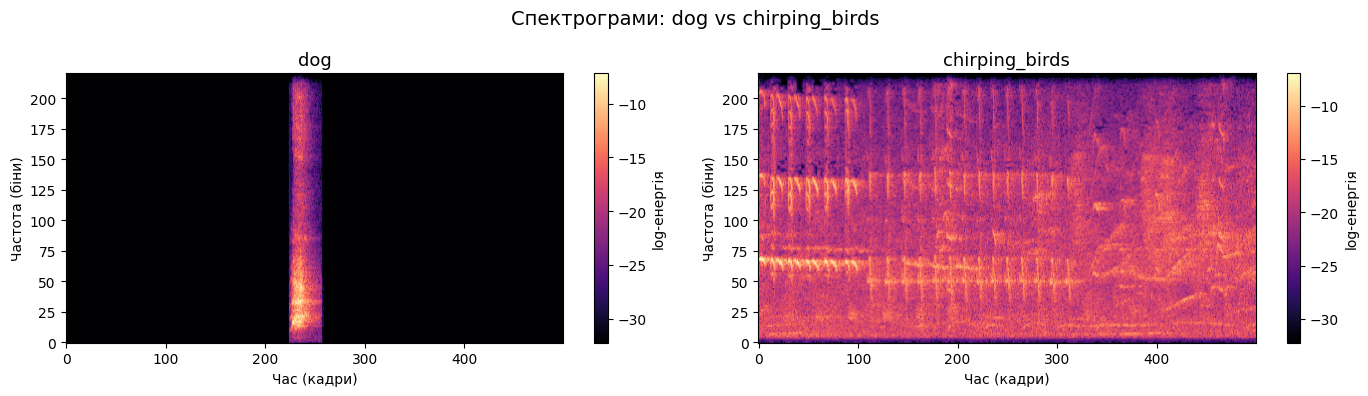

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for i, cat in enumerate(['dog', 'chirping_birds']):
    fname = df_sub[df_sub['category'] == cat].iloc[0]['filename']
    y_ex, sr_ex = librosa.load(os.path.join(audio_dir, fname), sr=22050, duration=5.0)
    spec_ex = make_spectrogram(y_ex, sr_ex)

    im = axes[i].imshow(spec_ex, aspect='auto', origin='lower', cmap='magma')
    axes[i].set_title(cat, fontsize=13)
    axes[i].set_xlabel('Час (кадри)')
    axes[i].set_ylabel('Частота (біни)')
    plt.colorbar(im, ax=axes[i], label='log-енергія')

plt.suptitle('Спектрограми: dog vs chirping_birds', fontsize=14)
plt.tight_layout()
plt.show()

# 7. SpectralClustering

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clust = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                            n_neighbors=10, random_state=42, n_jobs=-1)
cluster_labels = clust.fit_predict(X_scaled)

result_df = pd.DataFrame({'category': y_true, 'cluster': cluster_labels})
cross_tab = result_df.groupby(['category', 'cluster']).size().unstack(fill_value=0)
print("Крос-таблиця (рядки = реальний клас, стовпці = кластер):")
print(cross_tab)

Крос-таблиця (рядки = реальний клас, стовпці = кластер):
cluster          0   1
category              
chirping_birds   6  34
dog             28  12


# 8. Візуалізація через PCA

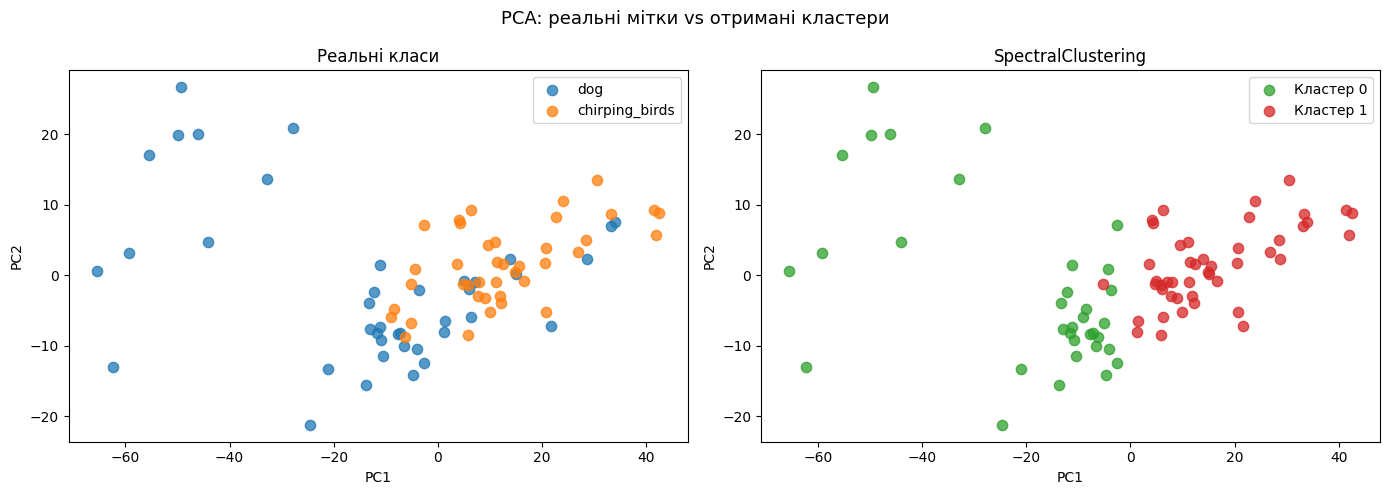

In [27]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for cat, color in zip(['dog', 'chirping_birds'], ['#1f77b4', '#ff7f0e']):
    mask = y_true == cat
    axes[0].scatter(X_2d[mask, 0], X_2d[mask, 1], label=cat, alpha=0.75, s=55, color=color)
axes[0].set_title('Реальні класи')
axes[0].legend()
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

for cid, color in zip([0, 1], ['#2ca02c', '#d62728']):
    mask = cluster_labels == cid
    axes[1].scatter(X_2d[mask, 0], X_2d[mask, 1], label=f'Кластер {cid}', alpha=0.75, s=55, color=color)
axes[1].set_title('SpectralClustering')
axes[1].legend()
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

plt.suptitle('PCA: реальні мітки vs отримані кластери', fontsize=13)
plt.tight_layout()
plt.show()

# 9. Оцінка якості кластеризації

In [28]:
label_map = {'dog': 0, 'chirping_birds': 1}
y_int = np.array([label_map[l] for l in y_true])

ari = adjusted_rand_score(y_int, cluster_labels)
print(f"Adjusted Rand Index: {ari:.3f}")
print("(1.0 = ідеальний збіг з реальними мітками, 0.0 = випадковий)")

Adjusted Rand Index: 0.294
(1.0 = ідеальний збіг з реальними мітками, 0.0 = випадковий)


# 10. Експеримент: різний ступінь стиснення

Перевіримо як розмір пулінгу впливає на якість кластеризації.

In [29]:
pool_sizes = [(5, 5), (10, 10), (20, 20), (40, 40)]
results = []

for ps in pool_sizes:
    feats_exp = []
    for _, row in df_sub.iterrows():
        path = os.path.join(audio_dir, row['filename'])
        y_f, sr_f = librosa.load(path, sr=22050, duration=5.0)
        spec_f = make_spectrogram(y_f, sr_f)
        pooled_f = pooling(spec_f, ps)
        feats_exp.append(pooled_f.flatten())

    X_exp = StandardScaler().fit_transform(np.array(feats_exp))
    c_exp = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                               n_neighbors=10, random_state=42, n_jobs=-1).fit_predict(X_exp)
    ari_exp = adjusted_rand_score(y_int, c_exp)
    results.append({'pool_size': str(ps), 'vector_len': X_exp.shape[1], 'ARI': round(ari_exp, 3)})
    print(f"Пулінг {ps}: вектор={X_exp.shape[1]} ознак, ARI={ari_exp:.3f}")

pd.DataFrame(results)

Пулінг (5, 5): вектор=4400 ознак, ARI=0.352
Пулінг (10, 10): вектор=1100 ознак, ARI=0.294
Пулінг (20, 20): вектор=275 ознак, ARI=0.171
Пулінг (40, 40): вектор=60 ознак, ARI=0.020


,pool_size,vector_len,ARI
0,"(5, 5)",4400,0.352
1,"(10, 10)",1100,0.294
2,"(20, 20)",275,0.171
3,"(40, 40)",60,0.020


## Висновки

**Що зробив:**  
Взяв 40 аудіофайлів із ESC-50 (по 20 на клас — гавкіт і спів птахів). Кожен файл перетворив у спектрограму через Short-Time FFT — це матриця, де по вертикалі частоти, по горизонталі час, а значення — log-енергія. Потім застосував max-pooling, щоб зменшити розмірність, розгорнув в вектор і запустив SpectralClustering.

**Чи потрапили різні звуки в різні кластери?**  
Так, переважно. З крос-таблиці видно, що більшість файлів кожного  класу зосередилась в окремому кластері. На PCA-графіку ці дві хмари  точок теж досить виразно  розділені в просторі.

**Що дав аналіз різного ступеня стиснення:**  
При надто сильному стисненні (наприклад, пулінг 40×40) якість кластеризації падає — ми  втрачаємо занадто багато інформації. При помірному стисненні (10×10 або 20×20) результат  хороший — ключові частотні характеристики зберігаються.

**Чому FFT корисний для вилучення ознак:**  
Сирий аудіосигнал — це просто набір амплітуд у часі, і за ними важко зрозуміти «що це за звук».  Після FFT ми бачимо частотний склад, гавкіт — це потужні короткі сплески на низьких і середніх частотах, а спів птахів — тонші високочастотні структури, що тягнуться в часі. Цей, частотний відбиток набагато більш інформативний для класифікації, ніж сирі амплітуди, і саме тому спектрограма є стандартним входом у задачах розпізнавання звуку.